# NBAS
NBAS variants are associated with 
[Infantile liver failure syndrome 2; OMIM:616483](https://omim.org/entry/616483) and
[Short stature, optic nerve atrophy, and Pelger-Huet anomaly; OMIM:614800](https://omim.org/entry/614800)

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.6.dev0


# NBAS
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NBAS.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'NBAS'
mane_tx_id = 'NM_015909.4'
mane_protein_id = "NP_056993.2"
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [5]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 67/67 [00:06<00:00, 10.33 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [6]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
55,Acute hepatic failure
34,Short stature
28,Elevated circulating aspartate aminotransferase concentration
27,Elevated circulating alanine aminotransferase concentration
20,Hyposegmentation of neutrophil nuclei
18,Prolonged prothrombin time
16,Hyperammonemia
16,Decreased circulating IgG concentration
15,Hepatomegaly
15,Increased total bilirubin


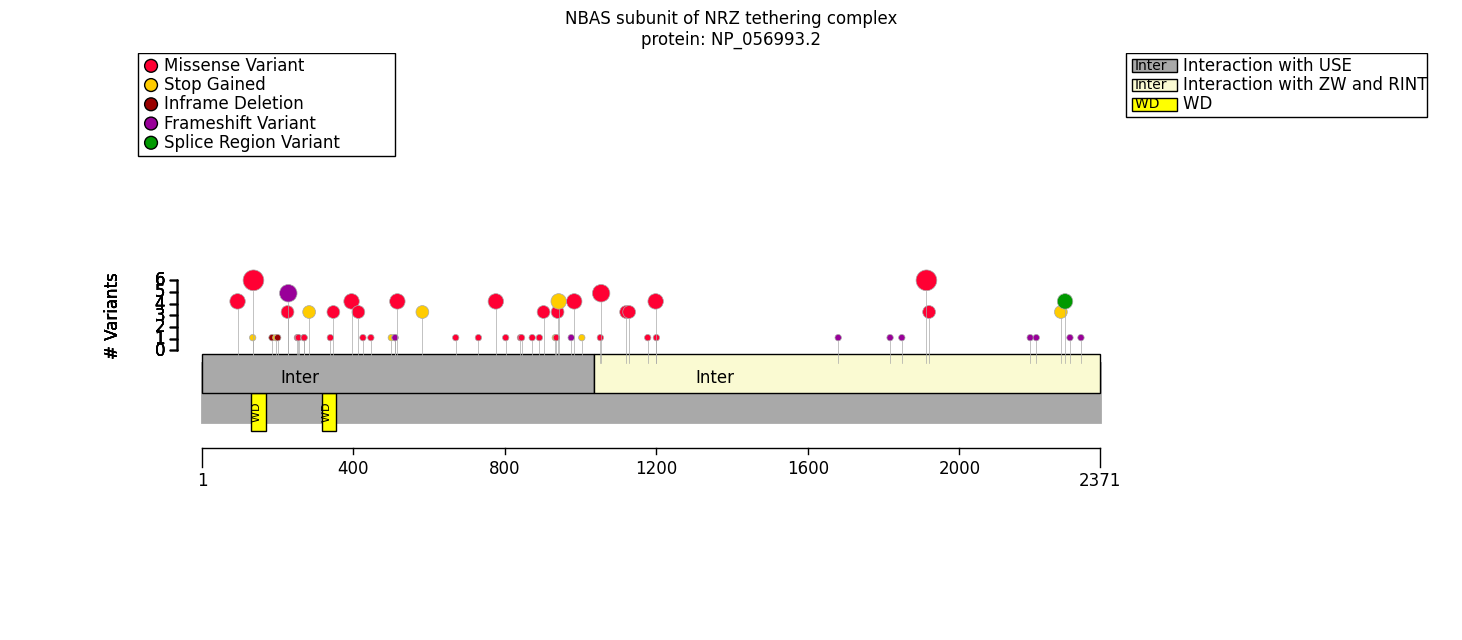

In [7]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

nbas_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
nbas_fig.tight_layout()

In [8]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
68,Interaction with USE1,Region,2 - 1035,p.Gln196Ter; p.Ile984Ser; p.His227Pro; p.Ile984LeufsTer8; p.Cys256Tyr; p.Val892Phe; p.Trp845Cys; p.Glu803Lys; p.Val842Phe; p.Ser976ProfsTer16; p.Glu447Lys; p.Ile512ThrfsTer4; p.Lys284Ter; p.Leu903Arg; p.Trp396Arg; p.Arg873Trp; p.Phe671Cys; p.Arg517His; p.Gly270Ala; p.Pro348Ser; p.Trp396Ter; p.Arg1004Ter; p.Thr731Pro; p.Cys426Trp; p.Ser414Phe; p.Arg517Cys; p.Ser230GlnfsTer4; p.Arg510Ter; p.Trp583Ter; p.Trp934Ter; p.Gly340Arg; p.Val253Gly; p.Arg137Trp; p.Pro777His; p.Leu271Pro; p.Gly254Asp; p.Trp135Ter; p.His940Pro; p.Glu943Ter; p.Ala95Val; p.Ile187del; p.Arg501Ter; p.Leu202del; p.Pro937Ala
7,WD 1,Repeat,131 - 169,p.Trp135Ter; p.Arg137Trp
3,WD 2,Repeat,317 - 355,p.Pro348Ser; p.Gly340Arg
34,Interaction with ZW10 and RINT1,Region,1037 - 2371,p.Ser1129Phe; p.Leu1055Pro; p.Met2204IlefsTer3; p.Arg1914His; p.Cys1199Tyr; p.Ser1819LysfsTer16; p.Ile1121Met; p.His1053Arg; p.Ala1921Pro; p.Ser1178Arg; p.Ser1681GlnfsTer37; p.Gln2322HisfsTer18; p.Glu2189Ter; p.Glu2269Ter; p.Leu2293CysfsTer9; p.Gln1201Pro; p.Arg1914Gly; p.Thr2280=; p.Trp1850GlyfsTer32


In [9]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
6,2_15539327_15539327_G_A,c.409C>T (p.Arg137Trp),7,missense
6,SO:1000029_HGNC:15625_NBAS,SV involving NBAS (p.?),,chromosomal deletion
5,2_15238670_15238670_C_T,c.5741G>A (p.Arg1914His),45,missense
4,2_15394320_15394320_A_G,c.3164T>C (p.Leu1055Pro),28,missense
4,2_15534602_15534602_G_GA,c.686dup (p.Ser230GlnfsTer4),9,frameshift
3,2_15374715_15374715_C_T,c.3596G>A (p.Cys1199Tyr),31,missense
3,2_15461210_15461210_G_T,c.2330C>A (p.Pro777His),21,missense
3,2_15415656_15415656_C_A,c.2827G>T (p.Glu943Ter),25,stop gained
3,2_15554064_15554064_G_A,c.284C>T (p.Ala95Val),4,missense
2,2_15475842_15475842_A_T,c.1186T>A (p.Trp396Arg),14,missense


# Genotype Phenotype Correlation (GPC) Analysis

[Hammann et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/38244286/) suggested that missense or in-frame deletions in the C-terminal region of the NBAS gene are associated with  [SOPH syndrome (614800)](https://omim.org/entry/608025), missense or in-frame deletions in the Sec30 domain of NBAS are associated with [infantile liver failure syndrome type 2](https://omim.org/entry/616483), and missense or in-frame deletions in the beta-propeller domain of NBAS are associated with a combined phenotype of multisystem involvement with acute liver failure.

The Sec30 domain is not included in the UniProt entry, but is located at residues 1025-1365 in the corresponding ProSite entry ([A2RRP1](https://www.ebi.ac.uk/interpro/protein/UniProt/A2RRP1/)) 

In [10]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=((0,),(2,1))
                                   )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,2
"Skipping ""general"" level terms",91
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),249


In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense,other/other OR missense/other,Corrected p values,p values
Decreased circulating IgG concentration [HP:0004315],1/12 (8%),15/23 (65%),0.035448,0.001611
Optic atrophy [HP:0000648],0/11 (0%),13/36 (36%),0.210010,0.021461
Hyposegmentation of neutrophil nuclei [HP:0011447],3/16 (19%),17/31 (55%),0.210010,0.028638
Osteopenia [HP:0000938],5/16 (31%),3/27 (11%),0.604896,0.125020
Malar flattening [HP:0000272],0/9 (0%),6/20 (30%),0.604896,0.137476
Pectus excavatum [HP:0000767],1/10 (10%),5/18 (28%),1.000000,0.374582
Acute hepatic failure [HP:0006554],19/20 (95%),36/43 (84%),1.000000,0.417571
Delayed skeletal maturation [HP:0002750],3/11 (27%),9/21 (43%),1.000000,0.464673
Decreased circulating IgA concentration [HP:0002720],0/9 (0%),3/20 (15%),1.000000,0.532020
Intellectual disability [HP:0001249],0/12 (0%),4/36 (11%),1.000000,0.559667


In [13]:
from gpsea.analysis.predicate import protein_region, allof, anyof
from gpsea.model.genome import Region

sec30 = protein_region(region=Region(1025,1365), tx_id=mane_tx_id)
inframe_del = variant_effect(VariantEffect.INFRAME_DELETION, tx_id=mane_tx_id)
missense_or_inframe = anyof((missense, inframe_del))
sec30_vars = allof((sec30, missense_or_inframe))
sec30_clf = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="Sec30",
                                   b_label="other",
                                   partitions=((0,1),(2,))
                                   )
sec30_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=sec30_result)


Allele group,missense/missense,other/other OR missense/other,Corrected p values,p values
Decreased circulating IgG concentration [HP:0004315],1/12 (8%),15/23 (65%),0.035448,0.001611
Optic atrophy [HP:0000648],0/11 (0%),13/36 (36%),0.210010,0.021461
Hyposegmentation of neutrophil nuclei [HP:0011447],3/16 (19%),17/31 (55%),0.210010,0.028638
Osteopenia [HP:0000938],5/16 (31%),3/27 (11%),0.604896,0.125020
Malar flattening [HP:0000272],0/9 (0%),6/20 (30%),0.604896,0.137476
Pectus excavatum [HP:0000767],1/10 (10%),5/18 (28%),1.000000,0.374582
Acute hepatic failure [HP:0006554],19/20 (95%),36/43 (84%),1.000000,0.417571
Delayed skeletal maturation [HP:0002750],3/11 (27%),9/21 (43%),1.000000,0.464673
Decreased circulating IgA concentration [HP:0002720],0/9 (0%),3/20 (15%),1.000000,0.532020
Intellectual disability [HP:0001249],0/12 (0%),4/36 (11%),1.000000,0.559667


In [14]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis

term_id = "OMIM:614800"  # Short stature, optic nerve atrophy, and Pelger-Huet anomalz
endpoint = disease_onset(disease_id=term_id)
survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)
print(result.pval)

0.3862204659641929


0.12464937285319636


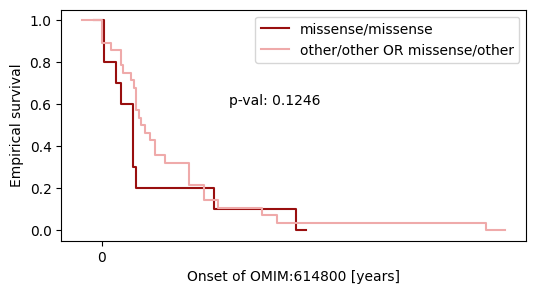

In [15]:
from gpsea.analysis.temporal.endpoint import death
from gpsea.model import Age
import matplotlib as mpl
import matplotlib.pyplot as plt

term_id = "OMIM:614800"  # Short stature, optic nerve atrophy, and Pelger-Huet anomalz
survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
mortality_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=death(),
)
print(mortality_result.pval)

mortality_fig, ax = plt.subplots(figsize=(6, 3))
_ = ax.xaxis.set(
    # Show X axis in years ...
    major_formatter=mpl.ticker.FuncFormatter(lambda x, pos: f"{x / Age.DAYS_IN_YEAR:.0f}"),
    # ... with a tick for every decade
    major_locator=mpl.ticker.MultipleLocator(10 * Age.DAYS_IN_YEAR),
)
_ = ax.set(
    xlabel=endpoint.name + " [years]",
    ylabel="Empirical survival",
)

ax.text(800, 0.6, f"p-val: {mortality_result.pval:.4f}")
result.plot_kaplan_meier_curves(ax)

# Summary

In [16]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
  GPAnalysisResultSummary.from_multi( result=missense_result  ),
  GPAnalysisResultSummary.from_multi( result=sec30_result  ),
)

m_results = (
    GPAnalysisResultSummary.from_mono(mortality_result),
)


caption = """It was reported that missense or in-frame deletions in the C-terminal region of the NBAS gene are associated with  SOPH syndrome (614800), 
missense or in-frame deletions in the Sec30 domain of NBAS are associated with infantile liver failure syndrome type 2 (616483), 
while missense or in-frame deletions in the beta-propeller domain of NBAS are associated with a combined phenotype of multisystem involvement with acute liver failure \\cite{PMID_38244286}.
In our dataset, we found an association with  missense or in-frame deletions in the Sec30 with decreased circulating IgG. A similar finding was obtain for missense variants in general.
Due to the small size of our cohort, this finding should be regarded as preliminary.
"""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [17]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,missense/missense,other/other OR missense/other,p-val,adj. p-val
Decreased circulating IgG concentration [HP:0004315],1/12 (8%),15/23 (65%),0.002,0.035
HPO Term,missense/missense,other/other OR missense/other,p-val,adj. p-val
Decreased circulating IgG concentration [HP:0004315],1/12 (8%),15/23 (65%),0.002,0.035
Description,Variable,Genotype (A),Genotype (B),p value
Compute time until postnatal death,Age of death,missense/missense,other/other OR missense/other,0.125


In [18]:
summarizer.process_latex(report=report, protein_fig=nbas_fig, stats_fig=mortality_fig)

Figure saved to ../../supplement/img/NBAS_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/NBAS_stats-draft.pdf
Output to ../../supplement/tex/NBAS_summary_draft.tex
